# CGAN

### Imports

In [1]:
import os
import numpy as np
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from tqdm.notebook import tqdm

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Parameters

In [2]:
os.makedirs("./images/cgan", exist_ok=True)
os.makedirs("./models", exist_ok=True)

params = {
    #Fixed
    "n_epochs" : 100,
    "batch_size" : 64,
    "lr" : 2e-4,
    "b1" : 0.5,
    "b2" : 0.999,

    #Block Config
    "g_block" : [128,256,512,1024],           #[128,256,512,1024],     #[64,128,256,512],
    "d_block" : [512,512,512],             #[512,512,512],          #[256,256,256],
    "n_classes" : 10,
    "latent_dim" : 100,

    #Fixed
    "img_size" : 32,
    "channels" : 1,
    "sample_interval" : 1,

    #LeNet Epochs - Strong/Weak classifiers
    "cnn_epochs" : 20,
    "cnn_epochs_w" : 8,

    #Label-smoothing
    "P_target" : 1.0,
    "N_target" : 0.0,

    #Virtual Batch Normalization
    "VB_norm" : False,

    #Loss / Non-saturating cost
    "loss" : "bce",                 #{"mse","bce","bce_ns"}

    #Checkpoint
    "load_chk" : False,
    "load_chk_cnn" : True,
}

img_shape = (params['channels'], params['img_size'], params['img_size'])

### Dataset - MNIST

In [3]:
# Configure data loader
os.makedirs("./data/mnist", exist_ok=True)

dataset = datasets.MNIST(
            "./data/mnist",
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.Resize(params['img_size']), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
            ),
        )
dataloader = DataLoader(
    dataset,
    batch_size=params['batch_size'],
    shuffle=True,
)

testset = datasets.MNIST(
            "./data/mnist",
            train=False,
            download=True,
            transform=transforms.Compose(
                [transforms.Resize(params['img_size']), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
            ),
        )
testloader = DataLoader(
    testset,
    batch_size=params['batch_size'],
    shuffle=True,
)

# Generator & Discriminator

### Model

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(params['n_classes'], params['n_classes'])

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(params['latent_dim'] + params['n_classes'], params['g_block'][0], normalize=False),
            *block(params['g_block'][0], params['g_block'][1]),
            *block(params['g_block'][1], params['g_block'][2]),
            *block(params['g_block'][2], params['g_block'][3]),
            nn.Linear(params['g_block'][3], int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(params['n_classes'], params['n_classes'])

        self.model = nn.Sequential(
            nn.Linear(params['n_classes'] + int(np.prod(img_shape)), params['d_block'][0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(params['d_block'][0], params['d_block'][1]),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(params['d_block'][1], params['d_block'][2]),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(params['d_block'][2], 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

### Loss Functions

In [5]:
# ylog(x) + (1-y)log(1-x)

#Non-Saturating
# (g, valid) -> - (1*log(x) + 0) -> minimize -log(D(G(z,l)))

#Saturating
# (g, fake) -> - (0*log(x) + 1*log(1-x)) -> minimize -log(1-D(G(z,l)))


### Training

In [6]:
def sample_image(n_row, epoch):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, params['latent_dim'])))).to(device)
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels)).to(device)
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "./images/cgan/%d.png" % epoch, nrow=n_row, normalize=True)

if not params['load_chk'] :

    # Loss functions
    if params['loss'] == "mse" :
        adversarial_loss = torch.nn.MSELoss()
    elif params['loss'] == "bce" :
        adversarial_loss = torch.nn.BCELoss()
    elif params['loss'] == "bce_ns" :
        adversarial_loss = torch.nn.BCELoss()
    else :
        raise NotImplementedError

    # Initialize generator and discriminator
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=params['lr'], betas=(params['b1'], params['b2']))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=params['lr'], betas=(params['b1'], params['b2']))

    # ----------
    #  Training
    # ----------
    g_loss_list = []
    d_loss_list = []

    for epoch in tqdm(range(params['n_epochs'])):
        for i, (imgs, labels) in enumerate(dataloader):

            batch_size = imgs.shape[0]

            # Adversarial ground truths
            valid = Variable(FloatTensor(batch_size, 1).fill_(params['P_target']), requires_grad=False).to(device)
            fake = Variable(FloatTensor(batch_size, 1).fill_(params['N_target']), requires_grad=False).to(device)

            # Configure input
            real_imgs = Variable(imgs.type(FloatTensor)).to(device)
            labels = Variable(labels.type(LongTensor)).to(device)

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, params['latent_dim'])))).to(device)
            gen_labels = Variable(LongTensor(np.random.randint(0, params['n_classes'], batch_size))).to(device)

            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity = discriminator(gen_imgs, gen_labels)
            #print(validity)

            #sat / non-sat G-Loss
            if params['loss'] == "bce_ns" :
                g_loss = adversarial_loss(validity, valid)
            elif params['loss'] == "bce" :
                g_loss = -adversarial_loss(validity, fake)
            else :
                g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # d_loss_list.append(-d_loss.item())
            # g_loss_list.append(g_loss.item())

        if epoch % params['sample_interval'] == 0:
            sample_image(n_row=5, epoch=epoch+1)
        
        print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch+1, params['n_epochs'], d_loss.item(), g_loss.item())
        )
        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())
    
    #Save final result
    sample_image(n_row=5, epoch=epoch+1)

    torch.save({
        'gen' : generator.state_dict(),
        'disc' : discriminator.state_dict(),
    }, './models/cgan_{}.pth'.format(params['n_epochs']))

  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 1/100] [D loss: 0.282644] [G loss: -0.106075]
[Epoch 2/100] [D loss: 0.116749] [G loss: -0.131931]
[Epoch 3/100] [D loss: 0.428414] [G loss: -0.165947]
[Epoch 4/100] [D loss: 0.390265] [G loss: -0.577370]
[Epoch 5/100] [D loss: 0.461502] [G loss: -0.599612]
[Epoch 6/100] [D loss: 0.588369] [G loss: -0.330175]
[Epoch 7/100] [D loss: 0.536100] [G loss: -0.544271]
[Epoch 8/100] [D loss: 0.636285] [G loss: -0.273628]
[Epoch 9/100] [D loss: 0.605282] [G loss: -0.589751]
[Epoch 10/100] [D loss: 0.628891] [G loss: -0.638107]
[Epoch 11/100] [D loss: 0.864537] [G loss: -1.250584]
[Epoch 12/100] [D loss: 0.669021] [G loss: -0.570465]
[Epoch 13/100] [D loss: 0.727082] [G loss: -1.118824]
[Epoch 14/100] [D loss: 0.536080] [G loss: -0.604130]
[Epoch 15/100] [D loss: 0.591440] [G loss: -0.601137]
[Epoch 16/100] [D loss: 0.623524] [G loss: -0.524294]
[Epoch 17/100] [D loss: 0.536547] [G loss: -0.685055]
[Epoch 18/100] [D loss: 0.617415] [G loss: -0.531380]
[Epoch 19/100] [D loss: 0.568477] [G 

### Loss Graph

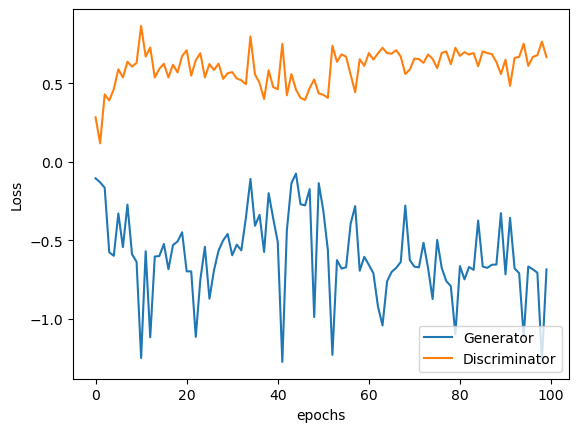

In [7]:
import matplotlib.pyplot as plt

fig, a = plt.subplots(1,1)

l1, = a.plot(g_loss_list, label='Generator')
l2, = a.plot(d_loss_list, label='Discriminator')
a.set_xlabel('epochs')
a.set_ylabel('Loss')
a.legend(handles=[l1,l2],loc='lower right')

plt.savefig('./gan_loss_graph.png',dpi=150)

# Evaluation

### CNN for classification

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
        self.conv1 = nn.Conv2d(1, 6, (5,5))
        # Layer 2: Convolutional. Output = 10x10x16.
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        # Layer 3: Fully Connected. Input = 400. Output = 120.
        self.fc1   = nn.Linear(400, 120)
        # Layer 4: Fully Connected. Input = 120. Output = 84.
        self.fc2   = nn.Linear(120, 84)
        # Layer 5: Fully Connected. Input = 84. Output = 10.
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        # Activation. # Pooling. Input = 28x28x6. Output = 14x14x6.
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
         # Activation. # Pooling. Input = 10x10x16. Output = 5x5x16.
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        # Flatten. Input = 5x5x16. Output = 400.
        x = x.flatten(start_dim=1)
        # Activation.
        x = F.relu(self.fc1(x))
        # Activation.
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

# Train & test part from https://github.com/activatedgeek/LeNet-5
def train(epoch, net):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        output = net(images.to(device))
        loss = criterion(output, labels.to(device))

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        #if i % 10 == 0:
        #    print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        loss.backward()
        optimizer.step()

def evaluate(target_loader, target_dataset, net):
    predictions = []
    true_labels = []
    outputs = []
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(target_loader):
        output = F.softmax(net(images.to(device)), dim=1)
        avg_loss += criterion(output, labels.to(device)).sum()
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.to(device).view_as(pred)).sum()
        predictions.append(pred.detach().cpu().numpy())
        true_labels.append(labels.detach().cpu().numpy())
        outputs.append(output.detach().cpu().numpy())

    avg_loss /= len(target_dataset)
    avg_loss = avg_loss.detach().cpu().item()
    accuracy = float(total_correct) / len(target_dataset)
    print('Test Avg. Loss: %f, Accuracy: %.3f' % (avg_loss, accuracy))
    #return accuracy, np.array(torch.cat(predictions))
    return accuracy, avg_loss, predictions, true_labels, outputs

### Training

In [9]:
if not params['load_chk_cnn'] :

    net = LeNet()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(net.parameters(), lr=0.001)
    optimizer = optim.SGD(net.parameters(), lr=0.001)
    net.to(device)

    print("Training...")
    val_acc_list = []
    val_loss_list = []

    for e in range(params['cnn_epochs']):
        print("Epoch : {}".format(e+1), end=' / ')
        train(e, net)
        val_acc, val_loss, _, _, _ = evaluate(testloader, testset, net)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    torch.save({
        'cnn' : net.state_dict()
        }, './models/cnn_{}.pth'.format(params['cnn_epochs']))

In [10]:
if not params['load_chk_cnn'] :

    net_w = LeNet()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(net.parameters(), lr=0.001)
    optimizer = optim.SGD(net_w.parameters(), lr=0.001)
    net_w.to(device)

    print("Training...")
    val_acc_list = []
    val_loss_list = []

    for e in range(params['cnn_epochs_w']):
        print("Epoch : {}".format(e+1), end=' / ')
        train(e, net_w)
        val_acc, val_loss, _, _, _ = evaluate(testloader, testset, net_w)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    torch.save({
        'cnn' : net_w.state_dict()
        }, './models/cnn_{}.pth'.format(params['cnn_epochs_w']))

### Load Checkpoint

In [11]:
if params['load_chk'] :

    #loading models from file
    generator = Generator()
    discriminator = Discriminator()

    chk = torch.load('./models/cgan_{}.pth'.format(params['n_epochs']), map_location=device)
    generator.load_state_dict(chk['gen'])
    discriminator.load_state_dict(chk['disc'])

    generator.to(device)
    discriminator.to(device)

In [12]:
if params['load_chk_cnn'] :

    net = LeNet()
    chk_cnn = torch.load('./models/cnn_{}.pth'.format(params['cnn_epochs']), map_location=device)
    net.load_state_dict(chk_cnn['cnn'])
    net.to(device)

    net_w = LeNet()
    chk_cnn_w = torch.load('./models/cnn_{}.pth'.format(params['cnn_epochs_w']), map_location=device)
    net_w.load_state_dict(chk_cnn_w['cnn'])
    net_w.to(device)

### TARR, Inception Score
- Use label (i) to generate image w/ CGAN -> (i) becomes ground-truth
- Compare Prediction Accuracy

In [13]:
class TestDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

def inception_score(r):
    p_y = np.mean(r, axis=0)
    e = r/p_y
    e = r*np.log(e, where= e>0)
    e = np.sum(e, axis=1)
    e = np.mean(e, axis=0)
    return np.exp(e)

In [14]:
# Generated Data for IS evaluation : 10,000 total, random distribution
test_size = 1000
criterion = nn.CrossEntropyLoss()
#test_labels = torch.arange(0, params['n_classes']).repeat(test_size)
test_labels = np.random.randint(0, params['n_classes'], test_size*params['n_classes'])

# Generate a batch of images
z = Variable(FloatTensor(np.random.normal(0, 1, (test_size*params['n_classes'], params['latent_dim'])))).to(device)
gen_labels = Variable(LongTensor(test_labels).to(device))
gen_imgs = generator(z, gen_labels)

gen_dataset = TestDataset(gen_imgs, gen_labels)
gen_loader = DataLoader(gen_dataset, batch_size=params['batch_size'], shuffle=True)

# Obtain Predictions (w/ softmax)
acc, _, predictions, true_labels, outputs = evaluate(gen_loader, gen_dataset, net)

r = np.concatenate(outputs)
i_score = inception_score(r)
print("Inception Score - CGAN : {:.3f}".format(i_score))

Test Avg. Loss: 0.024369, Accuracy: 0.945
Inception Score - CGAN : 7.794


In [15]:
# Baseline : Real Images (MNIST Test-set)
# acc_base, _, predictions_base, true_labels_base, outputs_base = evaluate(testloader, testset, net)

# r_base = np.concatenate(outputs_base)
# i_score_base = inception_score(r_base)
# print("Inception Score - Real Images : {:.3f}".format(i_score_base))

### Weak Classifier

In [16]:
# Obtain Predictions (w/ softmax)
print("Weak CNN")
acc, _, predictions, true_labels, outputs = evaluate(gen_loader, gen_dataset, net_w)

# Baseline : Real Images (MNIST Test-set)
# print("Weak CNN - real images")
# acc_base, _, predictions_base, true_labels_base, outputs_base = evaluate(testloader, testset, net_w)

Weak CNN
Test Avg. Loss: 0.027784, Accuracy: 0.825
